# COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

# covidtracking.columns

In [3]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']
df_state = df_state.sort_values('date', ascending=True)

# df_state.state.unique()

In [4]:
# Load in state population counts and merge with ctp data
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') 
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
negativeIncrease    0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [5]:
# Create state groupings (currently a manual process based on death rates over certain time periods)

grouped_cvd = df_state.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [6]:
# Calculate simple moving averages of the case counts and death counts.
case_SMA = []
death_SMA = []
negatives_SMA = []
for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    case_SMA.append(group_df.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(group_df.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(group_df.iloc[:,5].rolling(window=14).mean())
grouped_cvd['case_SMA']= pd.concat(case_SMA)
grouped_cvd['death_SMA']= pd.concat(death_SMA)
grouped_cvd['negatives_SMA']= pd.concat(negatives_SMA)

In [7]:
print(group_population)

   CVD_group  Population
0          0   124142431
1          1    89770981
2          2    89126756
3          3    25199355


In [8]:
# Create a table to analyze the summer outbreak
# How many extra deaths occurred as a result of the summer outbreak? 
# Calc = sum of actual deaths from COVID in the summer outbreak group
# minus the expected deaths from COVID based on 'no outbreak' death rate
summer_outbreak_table = (grouped_cvd[(grouped_cvd['CVD_group'].isin(['No outbreak', 'Summer outbreak']) 
                                      & (grouped_cvd['date'] >= '2020-07-05') 
                                      & (grouped_cvd['date'] <= '2020-10-01'))])
summer_group_actual_deaths = summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['deathIncrease'].sum()
summer_group_expected_deaths = (summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['deathIncrease'].sum() 
                                / summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] 
                                * summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0])
summer_group_excess_deaths = summer_group_actual_deaths  - summer_group_expected_deaths
summer_group_excess_deaths

25453.025312352715

In [9]:
summer_outbreak_table.head(1)

,CVD_group,date,fips,positiveIncrease,deathIncrease,negativeIncrease,Population,case_SMA,death_SMA,negatives_SMA
117,No outbreak,2020-07-05,621,15259,49,246788,124142431,13671.928571,152.357143,216673.071429


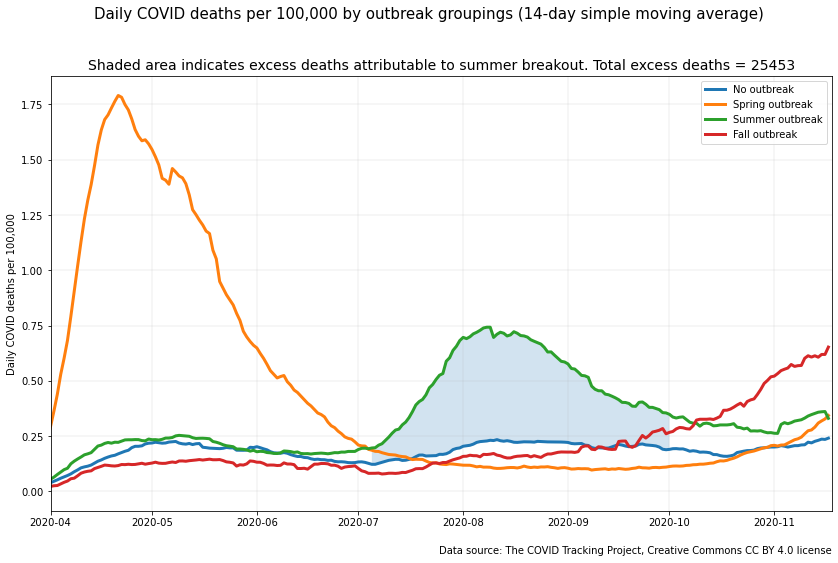

In [10]:
# Deaths per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1)
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.plot(group_df['date'], group_df['death_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3) 

ax.set_title(f'Shaded area indicates excess deaths attributable to summer breakout. Total excess deaths = {summer_group_excess_deaths:.0f}', size=14)
ax.set_ylabel('Daily COVID deaths per 100,000')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.fill_between(pd.date_range(datetime.date(2020, 7, 5),datetime.date(2020, 10, 1),freq='d'),
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0] * 100000,
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] * 100000,
                alpha = 0.2 )
ax.legend()
plt.savefig('img/COVID-deaths-by-outbreak-groupings.png')

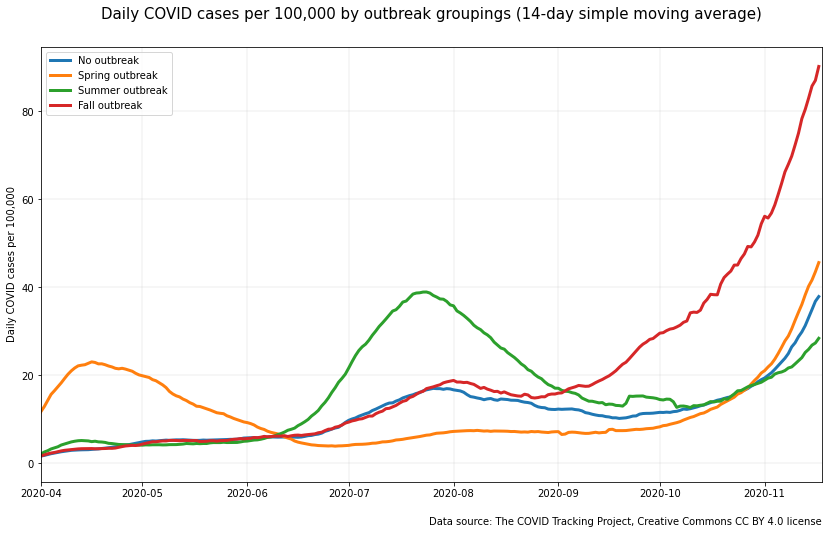

In [11]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings.png')

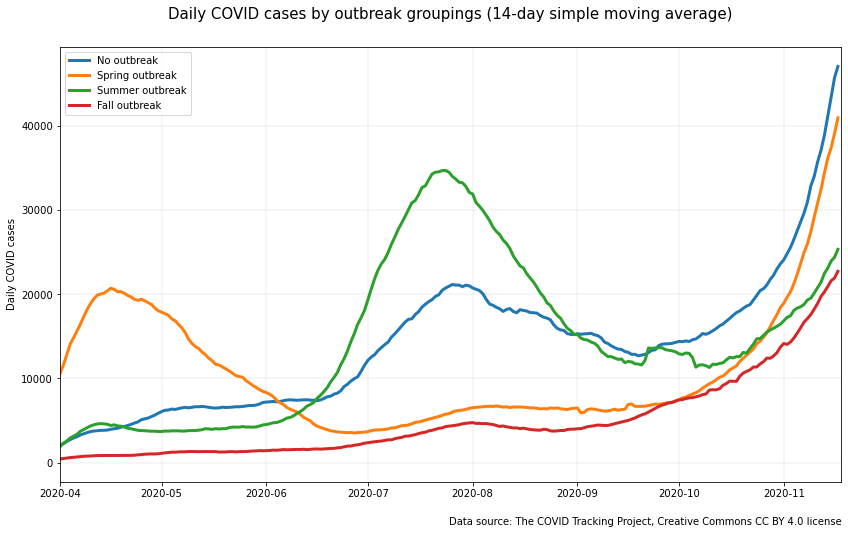

In [12]:
# Cases by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'], label = f'{chart_group} actuals', alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'], label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases')
ax.legend()

plt.savefig('img/COVID-total-cases-by-outbreak-groupings.png')

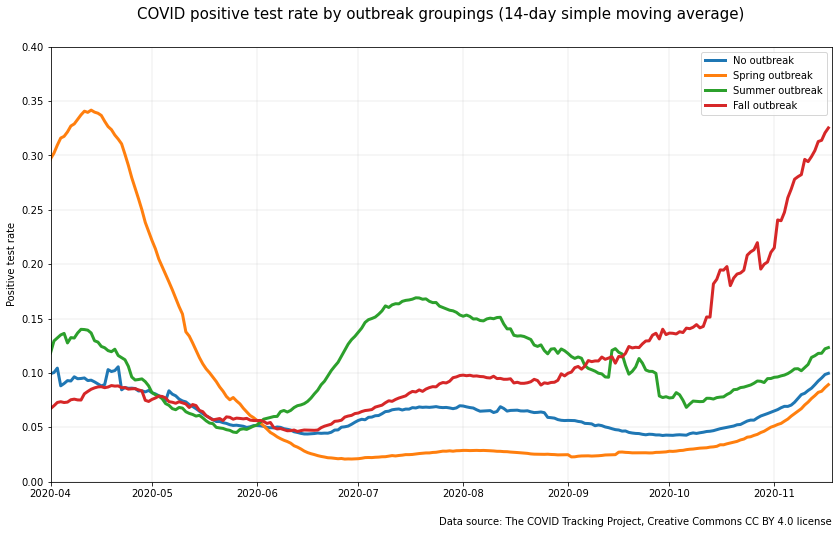

In [13]:
# Positivity rates by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / (group_df['positiveIncrease'] + group_df['negativeIncrease']), label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / (group_df['case_SMA'] + group_df['negatives_SMA']), label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.4)
ax.set_title(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Positive test rate')
ax.legend()

plt.savefig('img/COVID-positive-test-rate-by-outbreak-groupings.png')

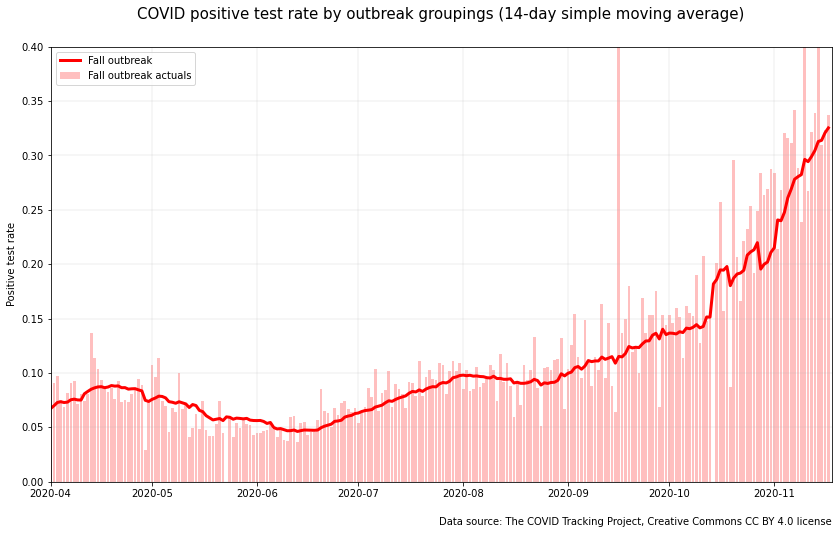

In [14]:
# Positivity rates by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    if chart_group == 'Fall outbreak':
        group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
        ax.bar(group_df['date'], group_df['positiveIncrease'] / (group_df['positiveIncrease'] + group_df['negativeIncrease']), label = f'{chart_group} actuals',  color = 'red', alpha=0.25)
        ax.plot(group_df['date'], group_df['case_SMA'] / (group_df['case_SMA'] + group_df['negatives_SMA']), color = 'red', label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.4)
ax.set_title(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Positive test rate')
ax.legend()

plt.savefig('img/COVID-positive-test-rate-by-outbreak-groupings-showing-daily-variability.png')

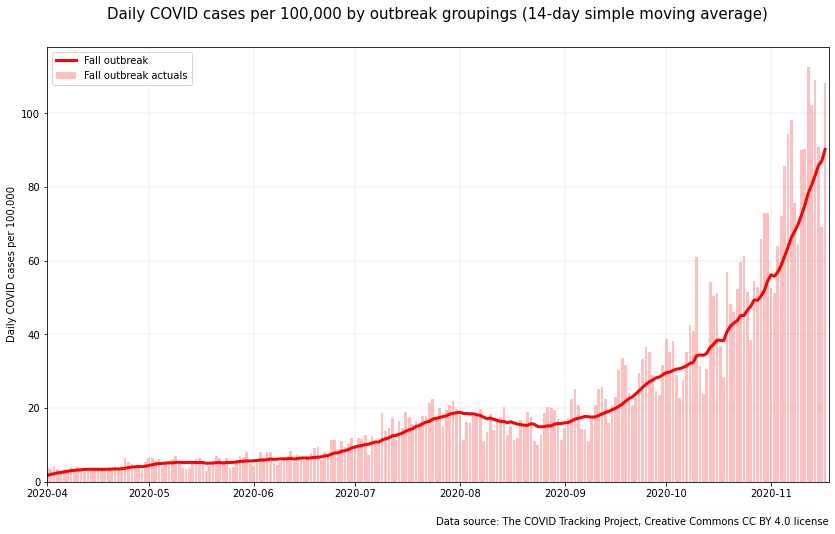

In [15]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    if chart_group == 'Fall outbreak':
        group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
        ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals', color = 'red',  alpha=0.25)
        ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group,color = 'red',  lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings-showing-daily-variability.png')

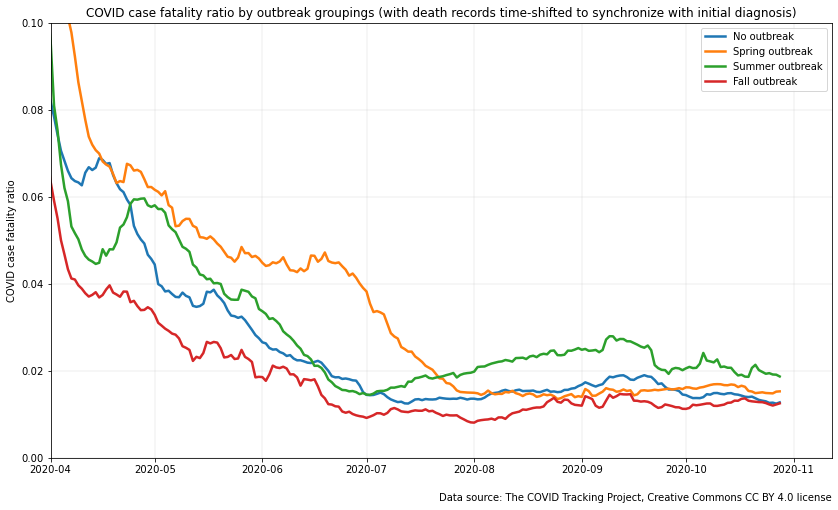

In [16]:
# Case fatality ratio by outbreak group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    temp_group_df = group_df[['date', 'death_SMA']]
    temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14) # shifting death records by 14 days to sync with cases
    group_df = group_df.merge(temp_group_df, on='date')
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['case_SMA'], label = chart_group, lw=2.5)

ax.set_ylabel('COVID case fatality ratio')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.1)
ax.set_title(f'COVID case fatality ratio by outbreak groupings (with death records time-shifted to synchronize with initial diagnosis)')
ax.legend()
plt.savefig('img/COVID-case-fatality-by-outbreak-groupings.png')